# Lesson 2: Dask DataFrames

In [40]:
import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from dask.distributed import Client

sns.set(style="white", context="talk")

%matplotlib inline

## Creating `dask` `DataFrames`

* read_table/read_csv
* read_parquet
* read_json
* from_pandas
* read_sql_table


* from_delayed
* from_dask_array
* `Bag.to_dataframe`

If you're using Dask, it's likely your data does not fit in memory.

__TODO: Show reading in CSV data__

## NYC Taxi Trips & Fares

There datasets are fairly __large__, and this is only for 2013...

http://www.andresmh.com/nyctaxitrips/

* [Trip Data](https://archive.org/download/nycTaxiTripData2013/trip_data.7z) - 4.1 GB
* [Fare Data](https://archive.org/download/nycTaxiTripData2013/trip_fare.7z) - 1.7 GB


## Lazily read the taxi data

In [2]:
client = Client()

In [3]:
trips = dd.read_parquet("data/taxi-small/trips.parq/")

Check the [read_parquet](https://docs.dask.org/en/latest/dataframe-api.html#dask.dataframe.read_parquet) parameters from time-to-time. Due to ongoing `pyarrow` improvements, parquet functionality is changing rapidly!

In [4]:
trips.npartitions

31

In [5]:
trips.head(compute=False)

,medallion_id,hack_license_id,rate_code,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude
npartitions=1,,,,,,,,
2013-12-01,uint16,uint16,uint8,uint32,uint32,float64,float64,float64
2013-12-02,...,...,...,...,...,...,...,...


We now have 32 tasks (31 partitions + 1 `head` task) that have not yet been evaluated.

## Selecting data

Use standard `pandas` boolean queries.

In [10]:
trips[trips.passenger_count > 4].shape[0].compute()

33249

This will be parallelized and is quite performant.

### Selection on the index is fast

In [6]:
xmas = trips.loc["2013-12-25", :]

In [7]:
%time xmas_df = xmas.compute()

CPU times: user 21 ms, sys: 4.62 ms, total: 25.6 ms
Wall time: 461 ms


In [8]:
xmas['trip_distance'].mean().compute()

3.154237343317597

In [9]:
first_half = trips.loc["2013-12-01":"2013-12-15", :]
first_half["trip_distance"].mean().compute()

2.9317822294093703

### `iloc` doesn't work

Dask does not keep track of partition length [(link)](https://docs.dask.org/en/latest/dataframe-indexing.html#positional-indexing).

In [ ]:
try:
    trips.iloc[:5, :]
except NotImplementedError as e:
    print(e)

## Setting the `Index`

Setting the index on a DataFrame is generally slow because requires a shuffle. We'll talk about [shuffling](https://docs.dask.org/en/latest/dataframe-groupby.html#difficult-cases) later.

Ideally, persist the index when you write data out to a format like Parquet to save time.

Let's try changing up the index now.

In [57]:
trips_hk = (trips.reset_index()
    .assign(date=lambda df: df.pickup_datetime.dt.normalize())
    .set_index("hack_license_id")
    .persist())

In [54]:
trips_hk.head()

,pickup_datetime,medallion_id,rate_code,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude
hack_license_id,,,,,,,,
1,2013-12-19 20:34:00,1,1,1,1200,6.55,-73.965477,40.806160
1,2013-12-11 20:56:00,1,1,1,2040,4.03,-73.979393,40.763634
1,2013-12-07 21:08:00,1,1,1,780,4.10,-73.979988,40.726803
1,2013-12-12 22:18:00,1,1,1,240,0.45,-73.978386,40.761879
1,2013-12-18 18:53:00,1,1,1,960,2.43,-74.002274,40.740200


In [47]:
trips_dt = trips.map_partitions(
    lambda df: df.assign(date=df.index.normalize())).persist()

In [48]:
trips_dt.head()

,medallion_id,hack_license_id,rate_code,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,date
pickup_datetime,,,,,,,,,
2013-12-01 00:00:00,3306,9702,1,1,360,2.07,-73.988358,40.723461,2013-12-01
2013-12-01 00:00:00,3540,6736,1,1,300,1.21,-73.947563,40.784515,2013-12-01
2013-12-01 00:00:00,5986,14096,1,3,840,3.85,-73.999901,40.728611,2013-12-01
2013-12-01 00:00:07,8899,18541,1,2,333,1.20,-73.951279,40.772842,2013-12-01
2013-12-01 00:00:08,7171,15110,1,1,331,1.00,-73.996834,40.753414,2013-12-01


## Merge/Join

In [ ]:
# fast
dd.merge(df1, df2, left_index=True, right_index=True)

In [ ]:
# fast
dd.merge(df1, df2, on=['idx', 'x']) # idx is index for both

In [ ]:
# join against another DataFrame
dd.merge(df1, df2, on='id')

## Groupby/Apply

Depending on how you're grouping, dask can take a slow or fast path.

Dask can efficiently perform split-apply-combinations the following conditions:

* group-on-index -> aggregate or apply
  * group-on-index + other columns -> aggregate or apply
* group -> aggregate

### Fast Groupby Aggregate/Apply

Aggregations, even on non-index columns, are quite fast.

In [12]:
hack_avg = trips.groupby('hack_license_id')['trip_distance'].mean().compute()

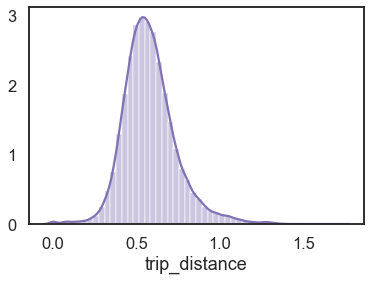

In [28]:
_ = sns.distplot(np.log10(1. + hack_avg), color="m")

Grouping along the index (or a computation on the index), is fast.

In [ ]:
trips_1d_v1 = trips.groupby(trips.index.dt.date).size().compute()

In [ ]:
trips_1d_v2 = trips.resample('1D').size().compute()

### Index + other columns is still fast

In [ ]:
%%time 
trips_1w = (trips.groupby([trips.index.dt.weekofyear, 'rate_code'])
    .mean().compute())

In [ ]:
# you can switch the order in this case and perf is the same
# trips.groupby(['rate_code', trips.index.dt.weekofyear]).mean().compute()

TODO: Show pd.grouper

### Slow apply

In [33]:
%%time
dist_time_corr = (
    trips.groupby("hack_license_id")
    .apply(lambda df: df.trip_time_in_secs.corr(df.trip_distance),
           meta=("corr", "f8"))
    .compute()
)

CPU times: user 1.12 s, sys: 84.4 ms, total: 1.2 s
Wall time: 5.53 s


### Slow aggregation

In [ ]:
trips.groupby(['pickup', 'x']).apply()

## Using the `index`

In [ ]:
# fast
dd.merge(df1, df2, left_index=True, right_index=True)

In [ ]:
# fast
dd.merge(df1, df2, on=['idx', 'x']) # idx is index for both

## Querying the data

## Merge/Join

In [ ]:
# fast
dd.merge(df1, df2, left_index=True, right_index=True)

In [ ]:
# fast
dd.merge(df1, df2, on=['idx', 'x']) # idx is index for both

In [ ]:
# join against another DataFrame
dd.merge(df1, df2, on='id')

## General computations

In [ ]:
df1.x + df2.y # fast

In [ ]:
df.rolling()

In [ ]:
df.where(df.x > 5, np.nan) # keep > 5 only, others nan
df.mask(df.5 < 5) # < 5 is nan

## Optimizing

Use categories if possible

## Don't do the shuffle

In [ ]:
df.set_index(df.x)

In [ ]:
dd.merge(df1, df2, on='not_index')

## Reshape/Pivot

* get_dummies
* pivot_table
* melt

## Dask Specific

df.map_partitions(

In [ ]:
repartition(divisions, npartitions, freq, partition_size) # one of these

In [ ]:
df.random_split([0.8, 0.2])

In [ ]:
df.rolling.map_overlap

# https://docs.dask.org/en/latest/dataframe-api.html#dask.dataframe.rolling.map_overlap

### Series

In [ ]:
map_overlap

In [ ]:
nunique_approx

`split_every`: Group partitions into groups of this size while performing a tree-reduction. If set to False, no tree-reduction will be used. Default is 8.

## Save Dataframes

* to_csv
* to_parquet
* to_hdf
* to_json

### From Dask DataFrames
* to_delayed
* to_records
* to_bag
